# Análisis del Acero 

### Descargar el Histórico
#### https://www.wsj.com/market-data/quotes/index/XX/STEEL/historical-prices
#### https://machinelearningmastery.com/random-forest-for-time-series-forecasting/


In [48]:
import pandas as pd
import datetime

In [49]:
steel = pd.read_csv('./steel_2010_221101.csv')
steel

,Date,Open,High,Low,Close
0,10/31/22,1515.46,1540.19,1502.85,1527.60
1,10/28/22,1549.91,1549.91,1495.24,1515.46
2,10/27/22,1569.01,1569.01,1540.51,1549.92
3,10/26/22,1549.37,1598.02,1546.81,1569.01
4,10/25/22,1545.64,1556.36,1516.04,1549.37
...,...,...,...,...,...
3223,01/08/10,1819.66,1872.38,1819.66,1866.62
3224,01/07/10,1827.25,1827.25,1794.30,1819.66
3225,01/06/10,1785.33,1834.36,1783.68,1827.25
3226,01/05/10,1770.72,1796.94,1767.13,1785.33


In [50]:
steel = steel.drop(columns=['Open', 'Low', 'Close'])
steel = steel.rename(columns={"High": "STEEL"})

In [51]:
steel['Date'] = steel['Date'].str[0:2]+'/'+steel['Date'].str[3:5]+'/20'+steel['Date'].str[6:9]

In [52]:
steel.describe()

,STEEL
count,3228.000000
mean,1272.399777
std,360.317227
min,456.510000
25%,1036.320000
50%,1241.275000
75%,1510.945000
max,2415.200000


In [53]:
steel['Date'] = pd.to_datetime(steel['Date'], format="%m/%d/%Y")
#steel

In [54]:
steel.index = pd.to_datetime(steel['Date'], format='%Y-%m-%d')
steel.index

DatetimeIndex(['2022-10-31', '2022-10-28', '2022-10-27', '2022-10-26',
               '2022-10-25', '2022-10-24', '2022-10-21', '2022-10-20',
               '2022-10-19', '2022-10-18',
               ...
               '2010-01-15', '2010-01-14', '2010-01-13', '2010-01-12',
               '2010-01-11', '2010-01-08', '2010-01-07', '2010-01-06',
               '2010-01-05', '2010-01-04'],
              dtype='datetime64[ns]', name='Date', length=3228, freq=None)

In [55]:
del steel['Date']

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
sns.set()

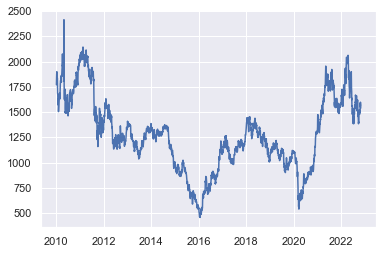

In [58]:
plt.plot(steel.index, steel['STEEL'], )

In [59]:
### Continuamos

In [60]:
data = steel
data = data.rename(columns={"STEEL": "y"})

In [61]:
data = data.sort_values('Date')

In [62]:
#data = data.tail(195)
print(data.shape)
data = data.rename(columns={"STEEL": "y"})
data
steel = data.copy()

(3228, 1)


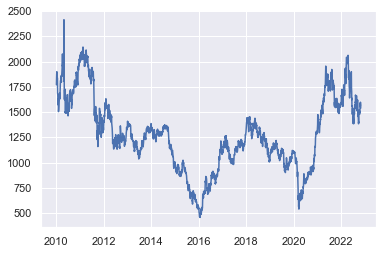

In [63]:
plt.plot(data.index, data['y'], )

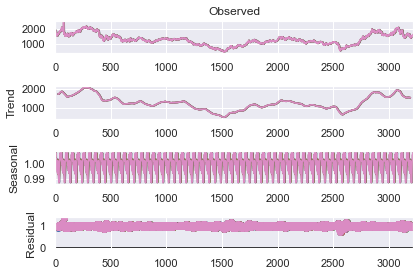

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot


result = seasonal_decompose(data, model='multiplicative', period=52)
result.plot()
pyplot.show()

>expected=1501.6, predicted=1531.8
>expected=1493.9, predicted=1485.0
>expected=1517.8, predicted=1503.4
>expected=1502.9, predicted=1520.1
>expected=1532.7, predicted=1481.0
>expected=1586.7, predicted=1541.4
>expected=1580.5, predicted=1596.7
>expected=1556.4, predicted=1576.2
>expected=1598.0, predicted=1556.0
>expected=1569.0, predicted=1619.5
>expected=1549.9, predicted=1568.7
>expected=1540.2, predicted=1563.1
MAE: 28.159


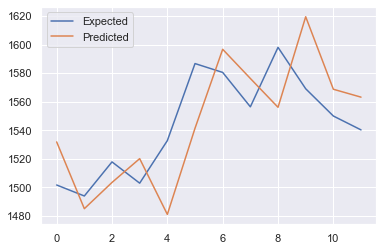

In [67]:
# forecast steel price with random forest
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
#series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
series = data.copy()
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [65]:
# finalize model and make a prediction for steel price with random forest
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# load the dataset
series = steel.copy()
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = RandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new prediction
row = values[-6:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [1580.45 1556.36 1598.02 1569.01 1549.91 1540.19], Predicted: 1540.879


In [66]:
series.tail(6)

,y
Date,
2022-10-24,1580.45
2022-10-25,1556.36
2022-10-26,1598.02
2022-10-27,1569.01
2022-10-28,1549.91
2022-10-31,1540.19
